<a href="https://colab.research.google.com/github/ChihabEddine98/AmazonAnalysis/blob/main/AmazonAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO LIST
--------


- [x] Genral collect for dataset
- [ ] Complete dataset
- [x] Make settings in an external file
- [ ] Make settings in an external file
- [ ] Make requirement installations in another file
- [ ] Clean Data & prepocessing
- [ ] Stemming / Lemmitization
- [ ] Replace Review Cleaning data by apply 


# Requirements Installations

In [1]:
# Run just once 
!pip install webdriver-manager
!pip install selenium
!pip install requests
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-le

In [2]:
# imports
import os
import sys
import requests as rq
import numpy as np
import pandas as pd
import re 
import spacy
import string
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from webdriver_manager.utils import ChromeType
import unicodedata
import pickle as pk
# end imports

# Part 01  : Data Gathering

In [ ]:
from google.colab import files
files.upload()

In [ ]:
settings_file = open("settings.pkl", "rb")
prod_urls = pk.load(settings_file)

## Scrapping Product Information

In [ ]:

# Scrapping Product Data 
def product_scrapper(driver,prod_category,prod_url):
    driver.get(prod_url)
    prod_soup = BeautifulSoup(driver.page_source,'html.parser')

    # Product Info
    prod_title = prod_soup.find('span',{'id' : 'productTitle' }).text
    prod_brand = prod_soup.find('a',{'id' : 'bylineInfo' }).text
    prod_rate = prod_soup.find('span',{'class' : 'a-icon-alt' }).text
    prod_eval = prod_soup.find('span',{'id' : 'acrCustomerReviewText' }).text
    try :
      prod_price = prod_soup.find('span',{'id' : 'priceblock_ourprice' }).text
    except AttributeError:
      prod_price = '0'

    result = tuple(map(lambda x : unicodedata.normalize("NFKD",x.strip()),[prod_title,prod_brand,prod_rate,prod_eval,prod_price,prod_category]))
    return result



## Scrapping Reviews Data

In [ ]:
# Scrapping Reviews Data
def reviews_scrapper(driver,prod,rev_url,ds):
    driver.get(rev_url)
    rev_soup = BeautifulSoup(driver.page_source,'html.parser')
    reviews_div = rev_soup.find_all('div',{'class':reviews_div_cls})

    for review in reviews_div:
        try :
          review_title = review.find('a',{'data-hook' : 'review-title'}).text
        except AttributeError:
          review_title = 'Null'
        
        try :
          review_rate = review.find('i',{'data-hook' : 'review-star-rating'}).text
        except AttributeError:
          review_rate = '0'
        
        review_body = review.find('span',{'data-hook' : 'review-body'}).text
        
        try :
          review_help = review.find('span',{'data-hook' : 'helpful-vote-statement'}).text
        except AttributeError:
          review_help = '0'
        try :
          review_home= review.find('span',{'data-hook' :'review-date'}).text 
        except AttributeError:
          review_home ='0'   
        
        rev_result = tuple(map(lambda x : unicodedata.normalize("NFKD",x.strip()),[review_title,review_rate,review_body,review_help,review_home]))
        ds.append(rev_result+(prod,))

    return ds

## Testing data collect

## Setup the web-driver 

In [ ]:
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',options = options)

## Scrapping Products

In [ ]:

lst_prod = [] 
for category,products in prod_urls.items():
    for prod in products:
        product = product_scrapper(driver,category,prod['prod_url'])+(prod['rev_count'],prod['prod_id'])
        lst_prod.append(product)




df_prod = pd.DataFrame(lst_prod)
df_prod.columns = prod_cols
df_prod


,Prod_Title,Prod_Brnd,Prod_Rate,Prod_Eval,Prod_Price,Category,Nb_Revs,Prod_ID
0,Berkey Bk4X2-Bb Système de filtration d'eau B...,Marque : Berkey,"4,7 sur 5 étoiles",1 657 évaluations,"329,99 €",electromenager,500,11
1,"AstroAI Mini Frigo de Chambre, Mini Réfrigér...",Visiter la boutique AstroAI,"4,1 sur 5 étoiles",15 470 évaluations,0,electromenager,1200,12
2,"Plaque à Induction AMZCHEF, Plaque de Cuisson...",Visiter la boutique AMZCHEF,"4,4 sur 5 étoiles",2 240 évaluations,0,electromenager,600,13
3,"SEVERIN Mini Réfrigérateur Mini Bar, Pose li...",Visiter la boutique Severin,"4,5 sur 5 étoiles",1 796 évaluations,0,electromenager,1000,14
4,Casio F-91W-1YER Montre Unisex Digitale avec B...,Visiter la boutique Casio,"4,6 sur 5 étoiles",46 434 évaluations,"12,38 €",montres,1200,15
5,Montre Mixte Casio Collection A168WA,Visiter la boutique Casio,"4,5 sur 5 étoiles",18 997 évaluations,"26,06 €",montres,1200,16
6,Casio G-SHOCK Homme Digital Quartz Montre avec...,Visiter la boutique Casio,"4,7 sur 5 étoiles",5 632 évaluations,"91,38 €",montres,1000,17
7,Diesel Homme Chronographe Quartz Montre avec B...,Marque : Diesel,"4,6 sur 5 étoiles",5 281 évaluations,"203,58 €",montres,1000,18
8,KATUR 9006 HB4 LED Ampoules de Phare Mini-Desi...,Visiter la boutique KATUR,"4,3 sur 5 étoiles",1 871 évaluations,0,auto et moto,600,19
9,Xiaomi MI Pump Mini Pompe à air Portable Adul...,Visiter la boutique Xiaomi,"4,7 sur 5 étoiles",2 510 évaluations,0,auto et moto,1000,10


## Scrapping Reviews Data




In [ ]:
# This function help us to generate the dataset of reviews
# and also the dataframe of several products

lst_rev = []
for category,products in prod_urls.items():
    for prod in products:
        for i in range(1,prod['rev_pages']+1):
            lst_rev = reviews_scrapper(driver,prod['prod_id'],f'{prod["rev_url"]}&pageNumber={i}',lst_rev) 

df_rev = pd.DataFrame(lst_rev)



In [ ]:
df_rev.head(30)

,Rev_Title,Rev_Rate,Rev_Bdy,Rev_Hlp,Rev_Home,Prod_ID
0,Excellent!,"4,0 sur 5 étoiles",Utilisateur du système de filtration par cart...,284 personnes ont trouvé cela utile,Commenté en France le 21 août 2018,11
1,enchantée,"5,0 sur 5 étoiles",J'étais un peu sceptique et vu le prix de l'a...,44 personnes ont trouvé cela utile,Commenté en France le 5 mai 2019,11
2,Très Satisfaite,"4,0 sur 5 étoiles",Très contente de mon achat: Je pense qu' il s...,35 personnes ont trouvé cela utile,Commenté en France le 10 mars 2019,11
3,Excellent rapport qualité/prix/longévité,"4,0 sur 5 étoiles","Très économe, ne consomme pas d'électricite...",29 personnes ont trouvé cela utile,Commenté en France le 19 septembre 2019,11
4,Au top,"5,0 sur 5 étoiles",Nous nous en servons pour filtrer l'eau du rob...,24 personnes ont trouvé cela utile,Commenté en France le 30 septembre 2019,11
5,Faites attention,"1,0 sur 5 étoiles",Pas de visse qui déconne au bout de 2mois alo...,17 personnes ont trouvé cela utile,Commenté en France le 12 février 2020,11
6,Système indispensable,"5,0 sur 5 étoiles",Une coupure d'eau courante m'a fait prendre co...,37 personnes ont trouvé cela utile,Commenté en France le 13 mars 2018,11
7,Parfait petit système de filtration,"5,0 sur 5 étoiles",Même si le tarif paraît un peu élevé ce sy...,31 personnes ont trouvé cela utile,Commenté en France le 25 juillet 2017,11
8,Filtre cassé !,"1,0 sur 5 étoiles",Bonjour j’etais ravi d’utiliser le filtre chim...,15 personnes ont trouvé cela utile,Commenté en France le 9 septembre 2019,11
9,Parfait,"5,0 sur 5 étoiles",je l'attendais depuis longtemps afin de suppri...,21 personnes ont trouvé cela utile,Commenté en France le 2 octobre 2016,11


# Part 02 : Data Cleaning

In [27]:

# Clean Review Body
def clean_review_body(rev):
  # Make text to lowerCase
  clean_rev = rev.lower()
  # Remove ponctuation like .,!? etc
  clean_rev = clean_rev.translate(str.maketrans('','',string.punctuation))
  # Remove words that contain numbers
  clean_rev = re.sub(r'\w*\d\w*','',clean_rev)
  return clean_rev
  
# Clean reviews DataFrame 
def clean_reviews(df_rev):
    # Cleaning Hlp Review
    df_rev['Rev_Hlp'] = df_rev.Rev_Hlp.apply(lambda x: re.sub("[^0-9]","",x))
    # Cleaning Rate review  
    df_rev['Rev_Rate'] = df_rev.Rev_Rate.str.split(' ').apply(lambda x: float(x[0].replace(',','.')))
    # Cleaning Home Review
    df_rev['Rev_Home'] = df_rev.Rev_Home.str.split(' ').apply(lambda x: x[2])

    # Cleaning the body of the review
    # Convert the letter into lowercase
    # Remove ponctuation like .,!? etc
    df_rev['Rev_Bdy'] = df_rev.Rev_Bdy.apply(lambda x: clean_review_body(x))
    
    df_rev = df_rev[df_rev.Rev_Home =='France']

    return df_rev



df_rev = pd.read_csv("dataset.csv")
df_rev = clean_reviews(df_rev)

ds = df_rev[df_rev["Rev_Home"] == 'France']
ds = ds[["Rev_Title","Rev_Bdy"]]

ds



,Rev_Title,Rev_Bdy
0,Génial !,jai commandé ce produit pour pouvoir écouter...
1,En panne après moins de 2 mois d'utilisation,pour un adaptateur de ce prix jaurais espéré...
2,Compatible pour Dualshock PS4,acheté pour branchée la manette sur le pc j...
3,Dongle Bluetooh parfait,jutilise ce dongle bluetooth sur un pc windows...
4,Impeccable,quand je vois certains commentaires de certain...
...,...,...
18211,Bien,un atout pour les sortie moto
18212,Top,top
18213,Au top,très pratiquepermet de gonfler les pneus des ...
18214,"Parfait, simple et transportable. Dommage, pas...",ras cest xiaomi et cest parfait presque petit ...


# Part 03 : Sentiment Analysis

## Extract useful data

In [28]:
# TreshHolds 
neg_th = 2
pos_th = 3.5 

def get_sentiment(rate):
    if rate < neg_th :
      return -1
    elif rate > pos_th :
      return 1
    else : 
      return 0

def useful_df(df_rev):
  X = df_rev.copy()
  X = X.drop('Rev_Rate', axis = 1)
  X = X.drop('Rev_Hlp', axis = 1)
  X = X.drop('Rev_Home', axis = 1)
  X = X.drop('Prod_ID', axis = 1)
  return X


X = useful_df(df_rev)
X

,Rev_Title,Rev_Bdy
0,Génial !,jai commandé ce produit pour pouvoir écouter...
1,En panne après moins de 2 mois d'utilisation,pour un adaptateur de ce prix jaurais espéré...
2,Compatible pour Dualshock PS4,acheté pour branchée la manette sur le pc j...
3,Dongle Bluetooh parfait,jutilise ce dongle bluetooth sur un pc windows...
4,Impeccable,quand je vois certains commentaires de certain...
...,...,...
18211,Bien,un atout pour les sortie moto
18212,Top,top
18213,Au top,très pratiquepermet de gonfler les pneus des ...
18214,"Parfait, simple et transportable. Dommage, pas...",ras cest xiaomi et cest parfait presque petit ...


## Data Matrix (Vectorizer)

In [29]:
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer

stopwords = stopwords.words('french')

def data_to_matrix(data):
  # Building the Victorizer
  stemmer = FrenchStemmer()
  analyzer = TfidfVectorizer().build_analyzer()
  vec = TfidfVectorizer(stop_words = stopwords,
                        analyzer = lambda doc:(stemmer.stem(w) for w in analyzer(doc)),
                        ngram_range = (1,3))
  # Build the new matrix dataset
  mx_rev = vec.fit_transform(data.Rev_Bdy) 
  df_rev = pd.DataFrame(mx_rev.toarray(),columns = vec.get_feature_names())
  df_rev.index = data.index
  df_rev.insert(0, 'Title', data.Rev_Title)
  return df_rev


mx_rev = data_to_matrix(X)
mx_rev

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Title,aa,aachet,ab,abaiss,abandon,abb,abdo,abdomen,abdominal,abdominauxbon,abdominauxel,abdominauxlivr,abdominauxvous,abdos,abdosj,aberr,abi,abim,able,ableavec,abledan,ablejav,ablel,ablement,ableon,ablepar,ableproduit,ablesm,ableun,abomin,abon,abond,abonnementd,abord,abordablej,abordables,about,abrit,absenc,...,yeux,yeuxd,yeuxm,yi,yog,yogaen,yolo,yop,you,youaaaaahouuuuj,youp,youpee,your,youtub,yva,zapp,zauss,ze,zeld,zelot,zen,zenvod,zero,zik,ziv,zon,zonetr,zoom,zouh,zow,zqsd,zte,zthank,zu,zufrieden,zut,œil,œuf,œuvr,μsd
0,Génial !,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,En panne après moins de 2 mois d'utilisation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Compatible pour Dualshock PS4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.191048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Dongle Bluetooh parfait,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Impeccable,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18211,Bien,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18212,Top,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18213,Au top,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18214,"Parfait, simple et transportable. Dommage, pas...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Subjectivity & Polarity of reviews 

In [30]:
!pip install textblob_fr
from textblob import TextBlob
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
import plotly.graph_objects as go
import plotly.express as px


tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

# To exctract polarity from a message **msg
def get_polarity(msg):
  return tb(msg).sentiment[0]

  
# To exctract subjectivity from a message **msg
def get_subjectivity(msg):
  return tb(msg).sentiment[1]




def encode_sentiment(sentiment):
    if sentiment == 'Positive' : 
      return 1
    elif sentiment == 'Negative' :
      return -1
    else : 
      return 0

def decode_sentiment(data):
    if data > 0 : 
      return 'Positive'
    elif data < 0 :
      return 'Negative'
    else : 
      return 'Neutral'



ds['Subjectivity'] = ds['Rev_Bdy'].apply(get_subjectivity)
ds['Polarity'] = ds['Rev_Bdy'].apply(get_polarity)
ds['Title_Polarity'] = ds['Rev_Title'].apply(get_polarity)
ds['Sentiment'] = ds['Polarity'].apply(decode_sentiment)

y = ds['Sentiment'].apply(encode_sentiment)

ds = ds.drop(ds[ds.Subjectivity > 1.0].index)

sentiment_stats = pd.value_counts(ds['Sentiment'].values, sort=True)
fig = px.histogram(ds, x="Sentiment",color="Sentiment")
fig.update_layout(
    title_text='Sentiment of reviews', # title of plot
    xaxis_title_text='Sentiment', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, 
    bargroupgap=0.1
)
fig.show()




## Visualize DataSet

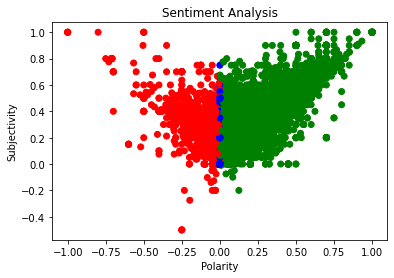

In [20]:
def visualize_data():
  col = np.where(ds['Sentiment'] == 'Positive','g',np.where(ds['Sentiment'] == 'Negative','r','b'))
  fig, ax = plt.subplots()
  scatter = ax.scatter(ds['Polarity'],ds['Subjectivity'], c = col)
  
  ax.set_title('Sentiment Analysis')
  ax.set_xlabel('Polarity')
  ax.set_ylabel('Subjectivity')


visualize_data()



# Part 04 : Build ML-Models 

## SVM Clasifier

In [32]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix


df = mx_rev.drop('Title',axis = 1) 
X_train , X_test , y_train , y_test = train_test_split(df,y,test_size = 0.2)

'''
params = {
    'kernel' : ['poly','rbf'],
    'C' : [1,2,5,10,20,50,100,200,1000,2000,5000],
    'gamma' : [1e-1,1e-2,1e-3, 1e-4,1e-5],
    'degree' : [2,3],
    'decision_function_shape' : ['ovo','ovr'],

}


svm = SVC()
grid = GridSearchCV(svm,param_grid = params)
grid.fit(X_train,y_train)
'''

svm = SVC(kernel='rbf', gamma= 0.001 , decision_function_shape='ovo', C= 1000)
svm.fit(X_train,y_train)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

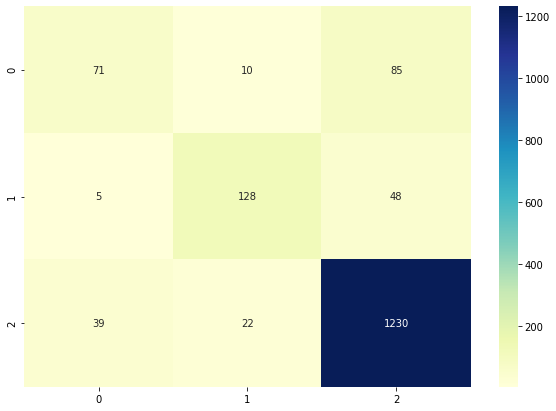

In [33]:
from sklearn.metrics import classification_report
import seaborn as sns


y_pred = svm.predict(X_test)

df_cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,fmt='1g',cmap="YlGnBu")


In [34]:

'''
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)
'''

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8724053724053724
              precision    recall  f1-score   support

          -1       0.62      0.43      0.51       166
           0       0.80      0.71      0.75       181
           1       0.90      0.95      0.93      1291

    accuracy                           0.87      1638
   macro avg       0.77      0.70      0.73      1638
weighted avg       0.86      0.87      0.86      1638



# KNN Model 


In [35]:
from sklearn.neighbors import KNeighborsClassifier

'''
Knn_params={
    'n_nieghbors':[3,5,9,11,15,20],
    'weights':['distance','uniform'],
    'metric':['euclidean','manhattan']
}
knn_grid = GridSearchCV(KNeighborsClassifier(),param_grid = Knn_params)
knn_grid.fit(X_train,y_train)
'''

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

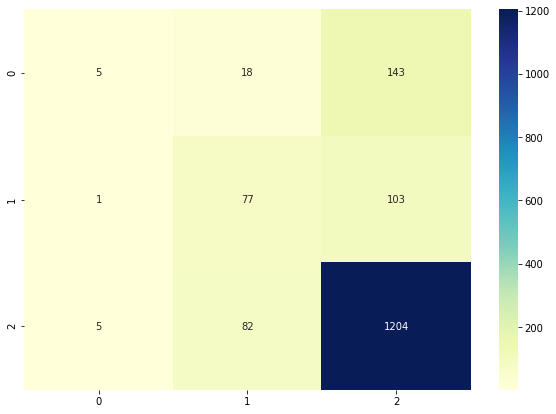

In [36]:
import seaborn as sns

y_pred = knn.predict(X_test)

df_cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,fmt='1g',cmap="YlGnBu")

In [37]:
'''
# print best parameter after tuning
print(Knn_grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(Knn_grid.best_estimator_)
'''

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7851037851037851
              precision    recall  f1-score   support

          -1       0.45      0.03      0.06       166
           0       0.44      0.43      0.43       181
           1       0.83      0.93      0.88      1291

    accuracy                           0.79      1638
   macro avg       0.57      0.46      0.46      1638
weighted avg       0.75      0.79      0.75      1638



# Logistic Regression Model


In [39]:
from sklearn.linear_model import LogisticRegression

'''
log_reg_params={ 
    'penalty' : ['l2'],
    'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver' : ['liblinear','lbfgs','liblinear']}
log_reg_grid = GridSearchCV(LogisticRegression(multi_class='multinomial'),param_grid = log_reg_params)    
log_reg_grid.fit(X_train,y_train)
'''

log_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=1.0)
log_regression.fit(X_train,y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

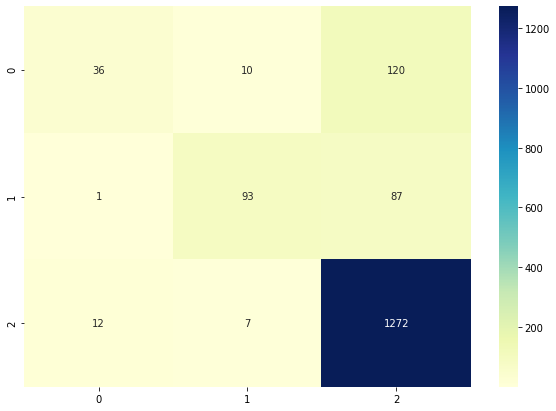

In [40]:
y_pred = log_regression.predict(X_test)

df_cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,fmt='1g',cmap="YlGnBu")


In [41]:
'''
# print best parameter after tuning
print(Knn_grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(Knn_grid.best_estimator_)
'''

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8553113553113553
              precision    recall  f1-score   support

          -1       0.73      0.22      0.33       166
           0       0.85      0.51      0.64       181
           1       0.86      0.99      0.92      1291

    accuracy                           0.86      1638
   macro avg       0.81      0.57      0.63      1638
weighted avg       0.85      0.86      0.83      1638



# Random Forest Classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier

'''
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

random_forest_params = dict(n_estimators = n_estimators, 
              max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

random_forest_grid = GridSearchCV(RandomForestClassifier(), random_forest_params)
random_forest_grid.fit(X_train,y_train)
'''
rand_forest=RandomForestClassifier()
rand_forest.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

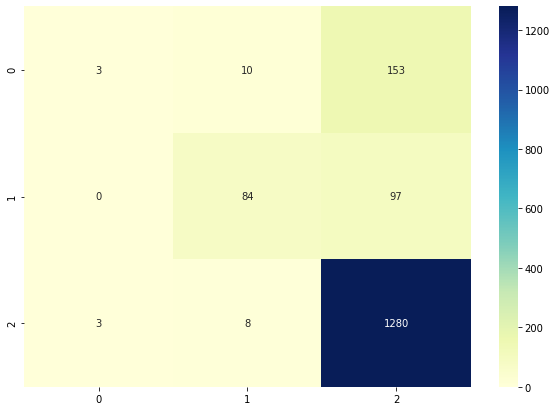

In [43]:
from sklearn.metrics import classification_report


y_pred = rand_forest.predict(X_test)
df_cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,fmt='1g',cmap="YlGnBu")

In [44]:
'''
# print best parameter after tuning
print(random_forest_grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(random_forest_grid.best_estimator_)
'''

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8345543345543346
              precision    recall  f1-score   support

          -1       0.50      0.02      0.03       166
           0       0.82      0.46      0.59       181
           1       0.84      0.99      0.91      1291

    accuracy                           0.83      1638
   macro avg       0.72      0.49      0.51      1638
weighted avg       0.80      0.83      0.78      1638

